In [1]:
import finesse
finesse.configure(plotting=True)

model = finesse.Model()
model.parse(
    """
    laser i1 P=1 f=0
    space s1 portA=i1.p1 portB=eo1.p1
    modulator eo1 15M 0.7 order=3
    space s2 portA=eo1.p2 portB=m1.p1
    mirror m1 R=0.9 T=0.1
    space s3 portA=m1.p2 portB=m2.p1 L=1
    mirror m2 R=0.9 T=0.1

    power_detector_dc refl node=m1.p1.o
    power_detector_dc trans node=m2.p2.o
    """
)

In [2]:
import numpy as np

for phase in np.linspace(0, 90, endpoint=True, num=6):
    model.parse(f"pd1 pdh{phase:.0f} node=m1.p1.o f=eo1.f phase={phase:.0f}")

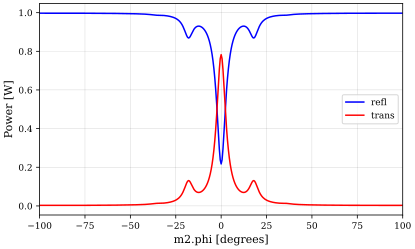

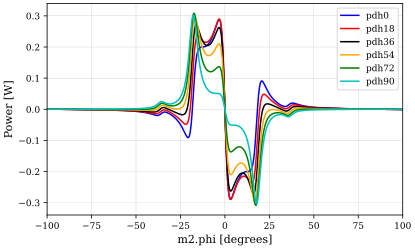

In [3]:
model.parse("xaxis(m2.phi, lin, -100, 100, 400)")
model.run().plot();

Removed pdh0
Removed pdh18
Removed pdh36
Removed pdh54
Removed pdh72
Removed pdh90


Maximum error signal gradient occurs at 9 degrees


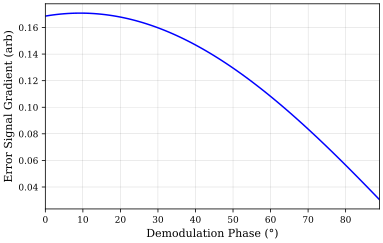

In [4]:
def remove_demod_pds(verbose=True):
    for el in model.elements:
        if el.startswith('pdh'):
            model.remove(el)
            if verbose: print(f'Removed {el}')

# Remove the old detectors.
remove_demod_pds()

# Create another array of phases.
phases = np.arange(0,90,1)
for phase in phases:
    model.parse(f"pd1 pdh{phase:.0f} node=m1.p1.o f=eo1.f phase={phase:.0f}")

# Sweep the mirror tuning across 3 points: ±1° and 0.
model.parse("xaxis(m2.phi, lin, -1, 1, 2)")
out = model.run()

# Calculate the gradient of the error signal.
grad = []
for phase in phases:
    var = out[f'pdh{phase}']
    grad.append((var[0] - var[-1])/2)

# Find the maximum gradient.
grad = np.array(grad)
idxmax = np.argmax(np.abs(grad))
print(f'Maximum error signal gradient occurs at {phases[idxmax]} degrees')

# Plot.
from matplotlib import pyplot as plt
plt.plot(phases,grad)
plt.xlabel('Demodulation Phase (°)')
plt.ylabel('Error Signal Gradient (arb)');

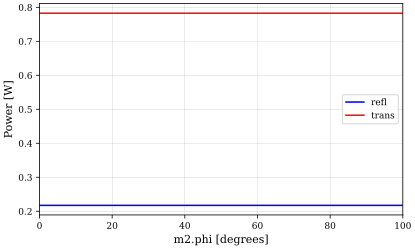

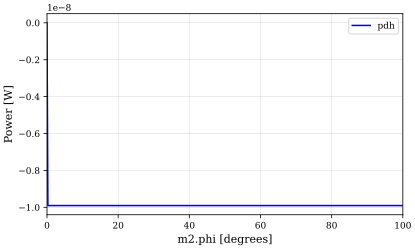

In [5]:
remove_demod_pds(verbose=False)
model.parse("""
power_detector_demod_1 pdh node=m1.p1.o f=eo1.f phase=9
lock lock_length pdh m1.phi -10 1e-8
xaxis(m2.phi, lin, 0, 100, 400, pre_step=run_locks())
""")
model.run().plot();

In [6]:
import finesse
import numpy as np
finesse.init_plotting()

model = finesse.Model()
model.parse(
    """
    laser i1 P=1 f=0
    space s1 portA=i1.p1 portB=eo1.p1
    modulator eo1 15M 0.7 order=3
    space s2 portA=eo1.p2 portB=m1.p1
    mirror m1 R=0.9 T=0.1
    space s3 portA=m1.p2 portB=m2.p1 L=1
    mirror m2 R=0.9 T=0.1

    pd1 pdh_complex m1.p1.o f=eo1.f
    """
)

In [7]:
eps = 1e-9 # finite difference step size for gradient calculation
model.parse(f"xaxis(m1.phi, lin, -{eps/2}, {eps/2}, 1, relative=True)")
sol = model.run()
# compute the real and imaginary gradient with respect to the
# cavity length change, then compute the complex argument (angle)
# to get the optimial demodulation phase
opt_demod = np.angle(
    np.gradient(
        sol['pdh_complex'], eps
    ).mean(), # take mean as we need
    deg=True # make sure we compute angle in degrees
)
print(opt_demod)

9.232551216511592


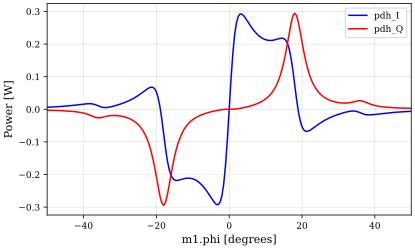

In [8]:
model.parse(f"""
pd1 pdh_I m1.p1.o f=eo1.f phase={opt_demod}
pd1 pdh_Q m1.p1.o f=eo1.f phase={opt_demod+90}
xaxis(m1.phi, lin, -50, 50, 200)
""")
sol = model.run()
sol.plot('pdh_I', 'pdh_Q');